# 17% of documents were missing; added at 13-12-2018 as freeze-2

In [1]:
import json
import os

from itertools import chain

In [2]:
COLLECTION_NAMES = ['figshare', 'hbovpk', 'leraar24', 'stimuleringsmaatregel', 'wur', 'wwmhbo']
DATA_ROOT = os.path.join('data2', 'output')

In [3]:
def load_data(collection_name):
    path = os.path.join(DATA_ROOT, collection_name, 'with_text.json')
    items = []
    with open(path) as stream:
        for item in json.load(stream):
            item['collection_name'] = collection_name
            items.append(item)
    return items

In [6]:
items = list(chain(*[load_data(name) for name in COLLECTION_NAMES]))

The total number of objects in all the collections combined.

In [7]:
len(items)

1283

## Count #documents/items

In [9]:
import pandas as pd

pd.Series([len(_['documents']) for _ in items]).value_counts()

1      1070
2        17
10       15
8        13
9        12
13       11
5         9
11        9
12        8
4         7
7         7
27        7
19        7
15        6
24        5
17        5
18        5
29        4
22        4
14        4
21        4
16        4
26        3
32        3
28        3
6         3
30        3
31        2
33        2
46        2
53        1
107       1
3         1
105       1
103       1
102       1
92        1
84        1
78        1
77        1
69        1
68        1
64        1
54        1
52        1
113       1
48        1
47        1
20        1
44        1
42        1
23        1
40        1
39        1
38        1
37        1
35        1
34        1
117       1
dtype: int64

# Flatten items to documents
* Skip documents with empty `text` field
* Add `collection_name` text field
* Rename `content_type` to `mime_type` if necessary
* Add item keywords to document keywords
* Add `item_id` for reference purposes
* Add `item_url` for refrence purposes

In [10]:
sum((len(_['documents']) for _ in items))

5415

In [11]:
HUMANIZED_MIME_TYPES = {
    'application/pdf': 'pdf',
    'application/vnd.openxmlformats-officedocument.presentationml.presentation': 'powerp.',
    'application/vnd.ms-powerpoint': 'powerp.',
    'application/msword': 'word',
    'application/vnd.openxmlformats-officedocument.wordprocessingml.document': 'word',
    'application/rtf': 'word',
    'text/plain': 'word',
    'application/vnd.openxmlformats-officedocument.spreadsheetml.sheet': 'excel',
    'text/html': 'html',
    'video': 'video',
    'image': 'image',
    'application/zip': 'zip',
    'audio/mpeg': 'audio',
    'application/octet-stream': 'other'
}

def humanize_mime_type(mime_type):
    if 'html' in mime_type:
        mime_type = 'text/html'
        
    if 'video' in mime_type:
        mime_type = 'video'
        
    if 'image' in mime_type:
        mime_type = 'image'
    
    return HUMANIZED_MIME_TYPES[mime_type]

In [27]:
documents = []

for item in items:
    for doc_index, document in enumerate(item['documents']):
        document['collection_name'] = item['collection_name']
        
        if document['collection_name'] == 'leraar24' and 'html' in document['mime_type']:
            document['mime_type'] = 'video'
            
        if not document['mime_type']:
            # Try to infer mime type
            if 'youtube' in document['url']:
                document['mime_type'] = 'video'
            elif 'wurtv' in document['url']:
                document['mime_type'] = 'video'
            else:
                print('ignoring', document['collection_name'], document['id'])
                continue

        document['humanized_mime_type'] = humanize_mime_type(document['mime_type'])
        document['keywords'] = item.get('keywords', [])
        document['item_id'] = item['id']
        document['item_url'] = item['url']
        documents.append(document)

ignoring figshare 3c19dd404129b88d8b21a258621d17c5380255c2
ignoring figshare 82b1ada3a67402c9c6c23aab1eb9ef4720077f6c
ignoring figshare 7fcb9cc26a86dbb2ec319480b24ef71d8540165b


In [13]:
len(documents)

5412

In [14]:
documents[0]

{'id': '5afabd996c9a78e915ab54655a6875c34787381e',
 'title': 'Powerpoint motivatietheorie',
 'language': 'en',
 'url': 'https://ndownloader.figshare.com/files/7026497',
 'text': 'Motivatietheorie – self detemination theory (SDT)\nRyan en Deci (2000)\n\n\n\n\n\n\n1\n\nDrie basisbehoeften\n\n\n\n\nRelatie\nCompetentie \nAutonomie \n\n\n\n\n2\n\n',
 'mime_type': 'application/vnd.openxmlformats-officedocument.presentationml.presentation',
 'collection_name': 'figshare',
 'humanized_mime_type': 'powerp.',
 'keywords': ['Utrecht University',
  'Universiteit Utrecht',
  'Education',
  'Higher Education',
  'Talentontwikkeling',
  'Motivatietheorie',
  'selfdetermination'],
 'item_id': 4308860,
 'item_url': 'https://api.figshare.com/v2/articles/4308860'}

## Additional filters
* Verify language is set
* Verify text is not null

In [47]:
from collections import Counter
from pprint import pprint

language_counter = Counter()
[language_counter.update((_['language']) for _ in documents)]
pprint(language_counter)

documents_filtered = [_ for _ in documents if _['language'] is not None]
print(len(documents_filtered))
documents_filtered_text = [_ for _ in documents_filtered if _['text'] is not None]
non_text_documents = [_ for _ in documents_filtered if _['text'] is None]
len(documents_filtered_text)
non_text_counter = Counter()
for document in non_text_documents:
    non_text_counter[document['humanized_mime_type']] += 1
pprint(non_text_counter)
len(documents_filtered_text)

Counter({'nl': 4620,
         'en': 606,
         None: 171,
         'af': 4,
         'la': 4,
         'da': 2,
         'fr': 2,
         'sa': 2,
         'ro': 1})
5241
Counter({'image': 1324, 'video': 2, 'other': 1})


1327

In [48]:
unique_documents = []
ids = set()
for d in documents_filtered_text:
    if d['id'] in ids:
        continue
    unique_documents.append(d)
    ids.add(d['id'])
len(unique_documents)

3886

In [49]:
sum([1 for _ in unique_documents if _['collection_name'] == 'wur'])

370

## Statistics for unfiltered corpus
Below are some plots for the unfiltered corpus, that is: the corpus before we selected the documents that should go into Elasticsearch.

In [50]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib as mpl
mpl.rcParams['font.size'] = 18
mpl.rcParams['figure.figsize'] = (10, 6)

In [51]:
def shorten_collection_name(name):
    if name == 'stimuleringsmaatregel':
        return 'stim. reg.'
    return name

In [52]:
df = pd.DataFrame([
    {
        'mime_type': _['humanized_mime_type'],
        'collection_name': shorten_collection_name(_['collection_name']),
        'language': _['language']
    }
    for _ in documents
])

print(df['collection_name'].value_counts())
num_documents = df['collection_name'].value_counts().sum()

wwmhbo        4322
wur            422
stim. reg.     388
leraar24       195
hbovpk          62
figshare        23
Name: collection_name, dtype: int64


FileNotFoundError: [Errno 2] No such file or directory: '/Users/matthijm/surfdrive/POL/scraped/freeze-2-raw-document-overview.png'

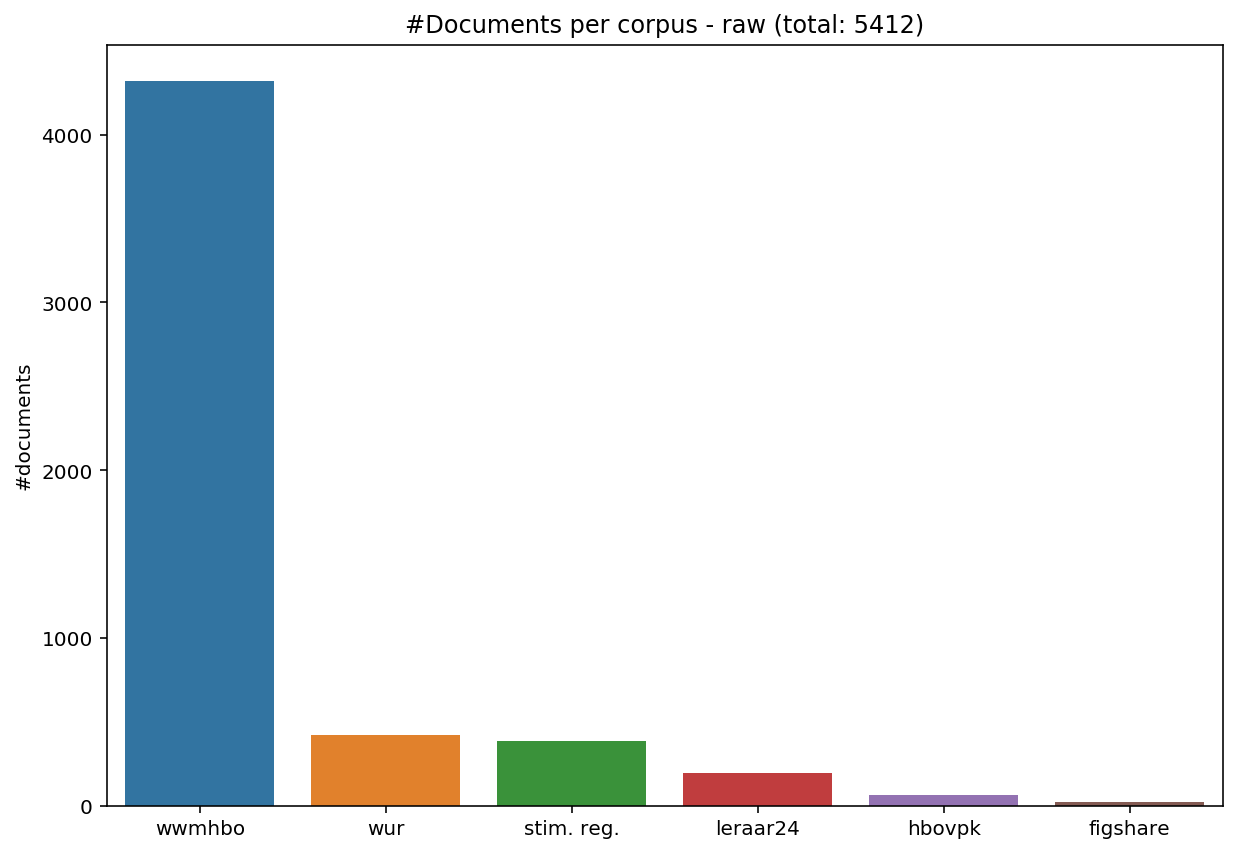

In [53]:
plt.figure(figsize=(10, 7))
corpus_counts = df['collection_name'].value_counts().to_frame().rename(columns={'collection_name': '#documents'})
sns.barplot(data=corpus_counts, x=corpus_counts.index, y='#documents')
plt.title('#Documents per corpus - raw (total: {})'.format(num_documents))
plt.savefig('/Users/matthijm/surfdrive/POL/scraped/freeze-2-raw-document-overview.png', dpi=150, bbox_inches='tight');

In [54]:
df['mime_type'].value_counts()

html       2561
image      1325
video       738
word        295
pdf         275
zip         135
powerp.      74
excel         6
other         2
audio         1
Name: mime_type, dtype: int64

FileNotFoundError: [Errno 2] No such file or directory: '/Users/matthijm/surfdrive/POL/scraped/freeze-2-raw-mime-types-all.png'

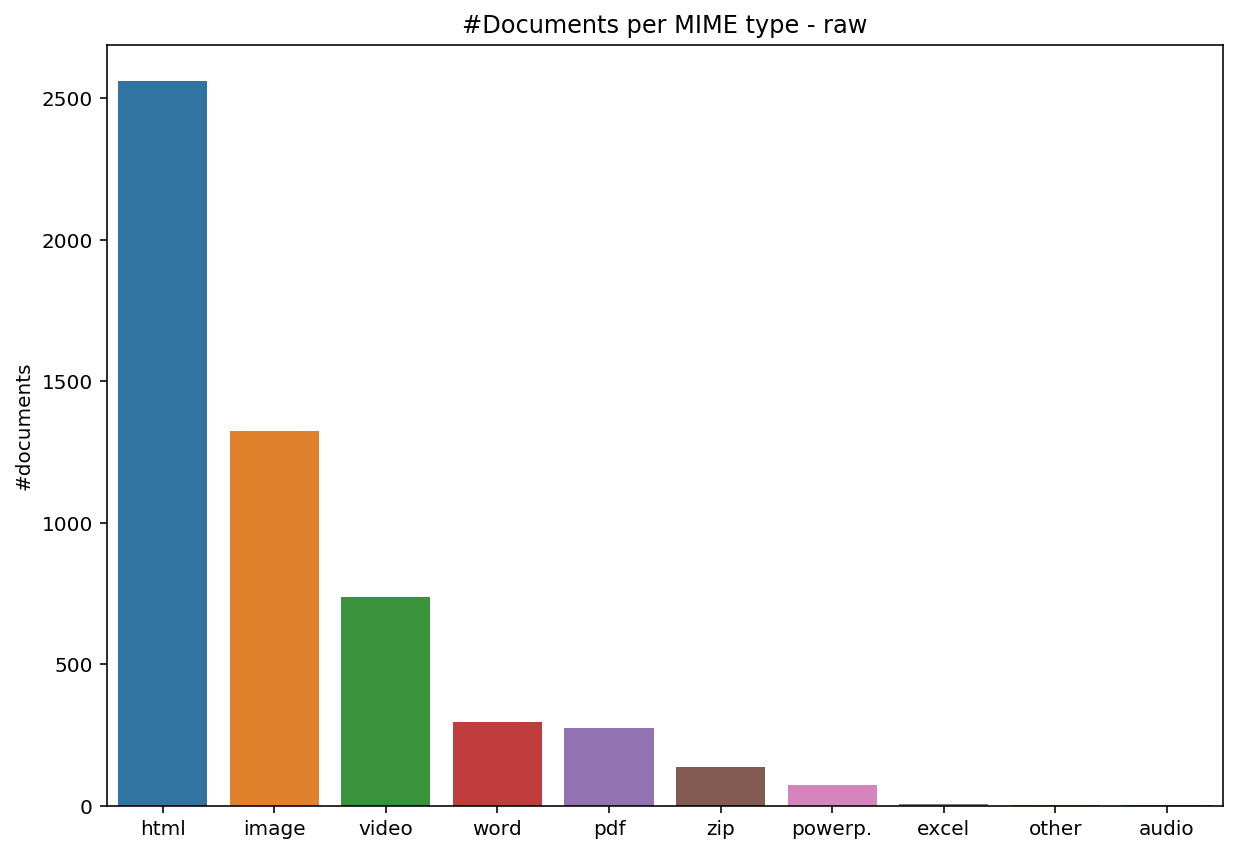

In [55]:
plt.figure(figsize=(10, 7))
mime_counts = df['mime_type'].value_counts().to_frame().rename(columns={'mime_type': '#documents'})
sns.barplot(data=mime_counts, x=mime_counts.index, y='#documents')
plt.title('#Documents per MIME type - raw');
plt.savefig('/Users/matthijm/surfdrive/POL/scraped/freeze-2-raw-mime-types-all.png', dpi=150, bbox_inches='tight');

FileNotFoundError: [Errno 2] No such file or directory: '/Users/matthijm/surfdrive/POL/scraped/freeze-2-raw-mime-types-per-collection.png'

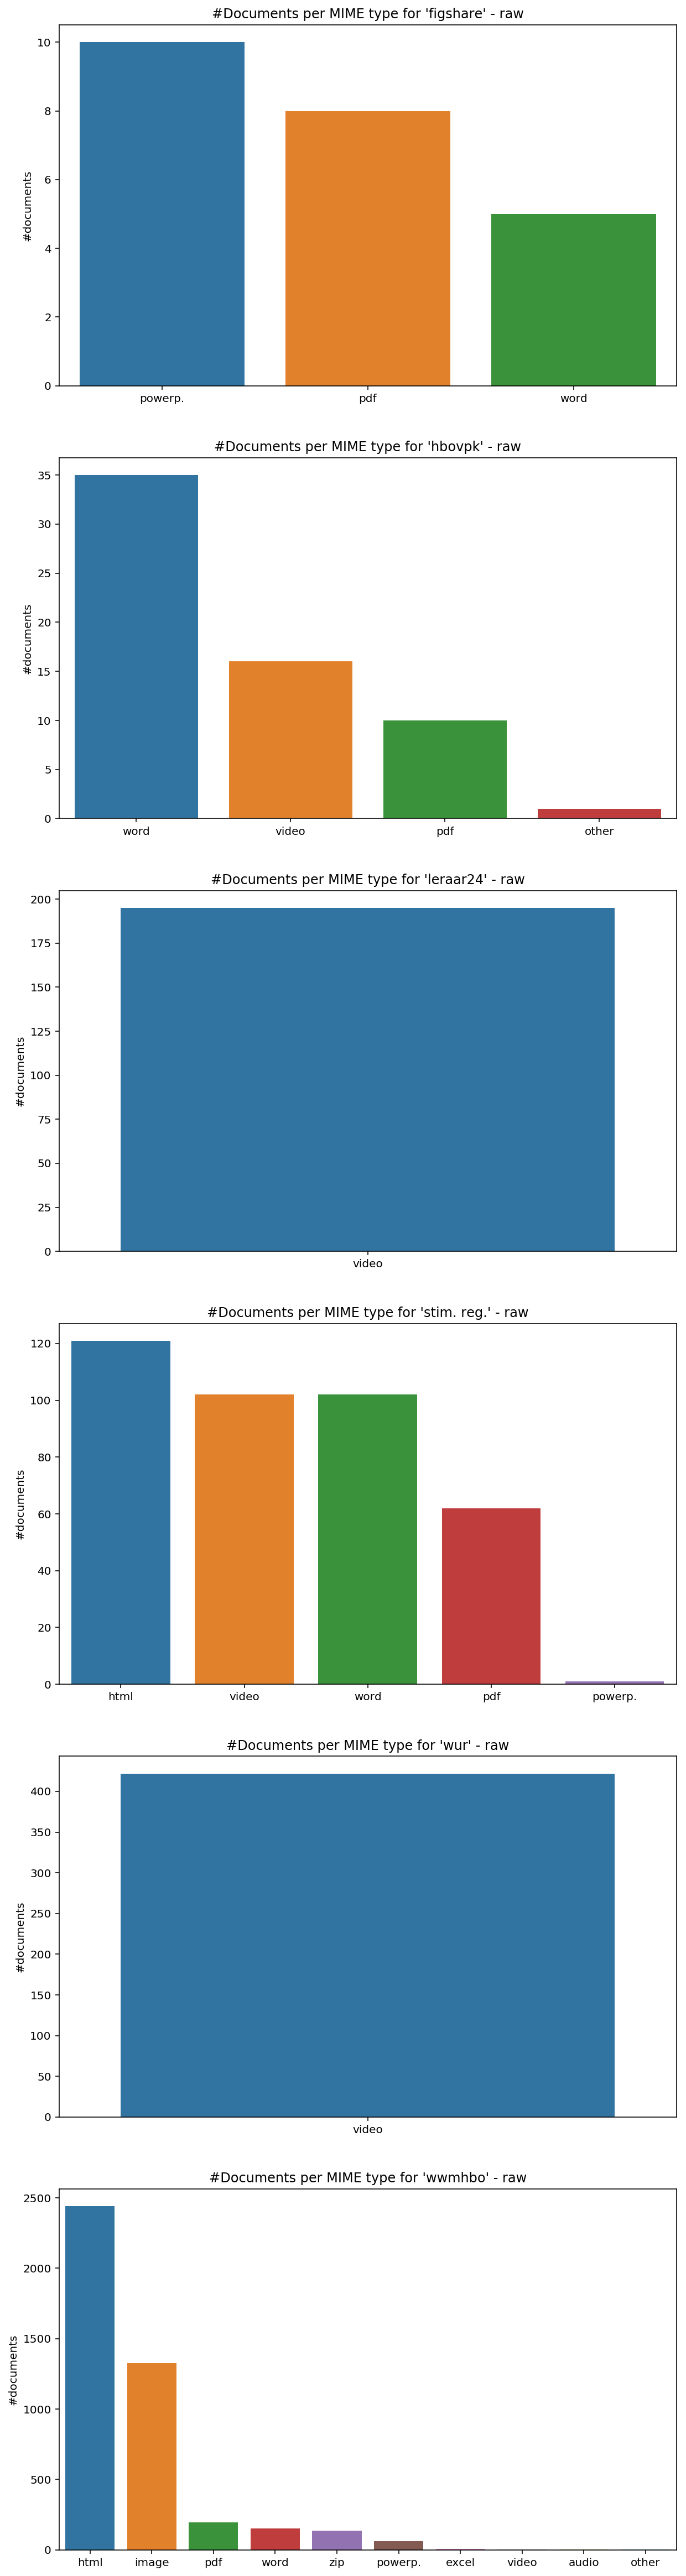

In [56]:
fig, axes = plt.subplots(
    nrows=len(COLLECTION_NAMES),
    ncols=1,
    figsize=(10, len(COLLECTION_NAMES) * 7)
)

for collection_name, ax in zip(COLLECTION_NAMES, axes):
    collection_name = shorten_collection_name(collection_name)
    mime_counts =\
        df.loc[df['collection_name'] == collection_name]['mime_type'].value_counts().to_frame().rename(columns={'mime_type': '#documents'})
    sns.barplot(data=mime_counts, x=mime_counts.index, y='#documents', ax=ax)
    ax.set_title('#Documents per MIME type for \'{}\' - raw'.format(collection_name));
    
plt.savefig('/Users/matthijm/surfdrive/POL/scraped/freeze-2-raw-mime-types-per-collection.png', dpi=150, bbox_inches='tight');

In [57]:
df['language'].value_counts()

nl    4620
en     606
af       4
la       4
sa       2
fr       2
da       2
ro       1
Name: language, dtype: int64

FileNotFoundError: [Errno 2] No such file or directory: '/Users/matthijm/surfdrive/POL/scraped/freeze-2-raw-languages-all.png'

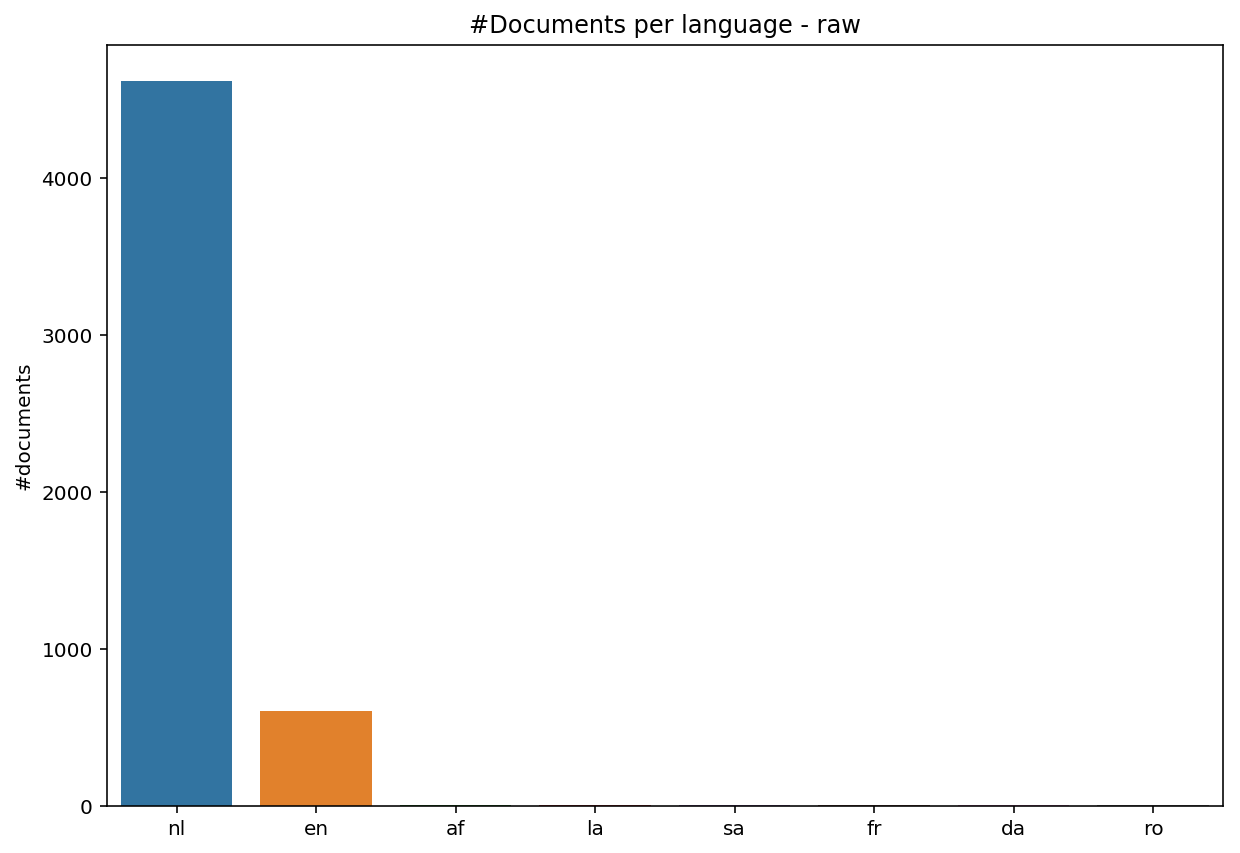

In [58]:
plt.figure(figsize=(10, 7))
mime_counts = df['language'].value_counts().to_frame().rename(columns={'language': '#documents'})
sns.barplot(data=mime_counts, x=mime_counts.index, y='#documents')
plt.title('#Documents per language - raw');
plt.savefig('/Users/matthijm/surfdrive/POL/scraped/freeze-2-raw-languages-all.png', dpi=150, bbox_inches='tight');

## Subset data for Elasticsearch ingest
* Select only video transcripts, Word & Powerpoint documents and PDFs
* Select only Dutch and English documents

In [61]:
counter = Counter()
for document in unique_documents:
    counter.update([document["humanized_mime_type"]])
pprint(counter)

Counter({'html': 2505,
         'video': 684,
         'pdf': 246,
         'word': 235,
         'zip': 135,
         'powerp.': 72,
         'excel': 6,
         'other': 1,
         'image': 1,
         'audio': 1})


In [62]:
es_documents = []

for document in unique_documents:
    h_mime_type = document['humanized_mime_type']
    if h_mime_type not in ['video', 'word', 'powerp.', 'pdf']:
        continue

    es_documents.append(document)

print(len(es_documents))
    
es_documents = [_ for _ in es_documents if _['language'] in ['nl', 'en']]
len(es_documents)

1237


1228

In [63]:
df = pd.DataFrame([
    {
        'mime_type': _['humanized_mime_type'],
        'collection_name': shorten_collection_name(_['collection_name']),
        'language': _['language']
    }
    for _ in es_documents
])

num_documents = df['language'].value_counts()
print(num_documents)
num_documents.sum()

nl    775
en    453
Name: language, dtype: int64


1228

## Save files going into ES to SURFdrive

In [ ]:
with open('/Users/matthijm/surfdrive/POL/scraped/freeze-2-elasticsearch-documents.json', 'wt') as stream:
    json.dump(es_documents, stream, indent=2)

## Statistics for documents going into Elasticsearch

In [ ]:
plt.figure(figsize=(10, 7))
corpus_counts = df['collection_name'].value_counts().to_frame().rename(columns={'collection_name': '#documents'})
sns.barplot(data=corpus_counts, x=corpus_counts.index, y='#documents')
plt.title('#Documents per collection - ES (total: {})'.format(num_documents.sum()));

plt.savefig('/Users/matthijm/surfdrive/POL/scraped/freeze-2-es-document-overview.png', dpi=150, bbox_inches='tight');

## MIME type overview per collection

In [ ]:
plt.figure(figsize=(10, 7))
mime_counts = df['mime_type'].value_counts().to_frame().rename(columns={'mime_type': '#documents'})
sns.barplot(data=mime_counts, x=mime_counts.index, y='#documents')
plt.title('#Documents per MIME type - ES');
plt.savefig('/Users/matthijm/surfdrive/POL/scraped/freeze-2-es-mime-types-all.png', dpi=150, bbox_inches='tight');

In [ ]:
fig, axes = plt.subplots(
    nrows=len(COLLECTION_NAMES),
    ncols=1,
    figsize=(10, len(COLLECTION_NAMES) * 7)
)

for collection_name, ax in zip(COLLECTION_NAMES, axes):
    collection_name = shorten_collection_name(collection_name)
    mime_counts =\
        df.loc[df['collection_name'] == collection_name]['mime_type'].value_counts().to_frame().rename(columns={'mime_type': '#documents'})
    
    sns.barplot(data=mime_counts, x=mime_counts.index, y='#documents', ax=ax)
    ax.set_title('#Documents per MIME type for \'{}\' - ES'.format(collection_name));
    
plt.savefig('/Users/matthijm/surfdrive/POL/scraped/freeze-2-es-mime-types-per-collection.png', dpi=150, bbox_inches='tight');

## List indices for verification

In [1]:
import json

with open('es-credentials.json') as stream:
    credentials = json.load(stream)

URL = credentials['url']
AUTH = (credentials['username'], credentials['password'])

In [2]:
import requests

print(requests.get('{}/{}'.format(URL, '_cat/indices'), auth=AUTH).text)

green open surfpol                 HpK6gE_JTzKiDZ04TbTDkA 5 1   64 5  2.5mb   1.2mb
green open surfpol-test            LXuJWnnrQN66oK7rOObVDw 3 2    0 0  2.2kb    783b
green open test                    sOkjwZuGTbekR7gMSXqXYA 5 1 1297 0 25.8mb  12.9mb
green open freeze-2                Ar8aohYxQpaoDSQOLbRHzQ 5 1 1228 0 22.4mb  11.2mb
green open first_index             -uWjc3vwRxGwOv95YG2qlQ 1 1    2 0 14.7kb   7.3kb
green open freeze-2-title-keywords QzU8YtCCSQisddOI8CskGA 5 1 1228 0  1.8mb 960.7kb
green open freeze-1                zqAnwnaXRaWgXgNaDZ9Jmw 5 1 1147 0 21.5mb  10.7mb



## Create new index for freeze-2

In [ ]:
requests.put(
    '{}/{}'.format(URL, 'freeze-2'),
    json={
        'mappings': {
            '_doc': {
                'properties': {
                    'title': {'type': 'text'},
                    'text': {
                        'type': 'object',
                        'properties': {
                            'en': {
                                'type': 'text',
                                'analyzer': 'english'
                            },
                            'nl': {
                                'type': 'text',
                                'analyzer': 'dutch'
                            }
                        }
                    },
                    'url': {'type': 'text'},
                    'keywords': {'type': 'text'},
                    'mime_type': {'type': 'text'},
                    'humanized_mime_type': {'type': 'text'},
                    'item_id': {'type': 'text'},
                    'item_url': {'type': 'text'},
                    'collection_name': {'type': 'text'}
                }
            }
        }
    },
    auth=AUTH
).text

## Delete index (CAREFUL)

In [ ]:
# import requests

# requests.delete('{}/{}'.format(URL, 'freeze-1'), auth=AUTH)

## Ingest into ES

In [ ]:
import re
import copy
from progressbar import ProgressBar

for doc in ProgressBar()(es_documents):
    clean_text = re.sub(r'\s+', ' ', doc['text'])

    es_doc = copy.deepcopy(doc)
    es_doc['text'] = dict()
    if es_doc['language'] == 'nl':
        es_doc['text']['nl'] = clean_text
    elif es_doc['language'] == 'en':
        es_doc['text']['en'] = clean_text
    else:
        raise ValueError('this shouldn not happen')
    
    url = '{}/freeze-2/_doc/{}'.format(URL, doc['id'])
    requests.put(url, auth=AUTH, json=es_doc)

In [ ]:
requests.get('{}/{}/_doc/{}'.format(URL, 'freeze-2', es_documents[0]['id']), auth=AUTH).text

## List indices for verification

In [74]:
import requests

print(requests.get('{}/{}'.format(URL, '_cat/indices'), auth=AUTH).text)

green open surfpol                 HpK6gE_JTzKiDZ04TbTDkA 5 1   64 5  2.5mb   1.2mb
green open surfpol-test            LXuJWnnrQN66oK7rOObVDw 3 2    0 0  2.2kb    783b
green open test                    sOkjwZuGTbekR7gMSXqXYA 5 1 1297 0 25.8mb  12.9mb
green open freeze-2                Ar8aohYxQpaoDSQOLbRHzQ 5 1 1228 0 22.4mb  11.2mb
green open first_index             -uWjc3vwRxGwOv95YG2qlQ 1 1    2 0 14.7kb   7.3kb
green open freeze-2-title-keywords QzU8YtCCSQisddOI8CskGA 5 1 1228 0  1.8mb 960.7kb
green open freeze-1                zqAnwnaXRaWgXgNaDZ9Jmw 5 1 1147 0 21.5mb  10.7mb



In [6]:
print(requests.get('{}/{}'.format(URL, '_analyze'),
                   json={
                      "analyzer" : "english",
                      "text" : "Is reduced by dean methylation of the d.n.a.. Allowing the."
                    }, 
                   auth=AUTH).text)

{"tokens":[{"token":"reduc","start_offset":3,"end_offset":10,"type":"<ALPHANUM>","position":1},{"token":"dean","start_offset":14,"end_offset":18,"type":"<ALPHANUM>","position":3},{"token":"methyl","start_offset":19,"end_offset":30,"type":"<ALPHANUM>","position":4},{"token":"d.n.a","start_offset":38,"end_offset":43,"type":"<ALPHANUM>","position":7},{"token":"allow","start_offset":46,"end_offset":54,"type":"<ALPHANUM>","position":8}]}


## Do a test query

In [75]:
requests.get(
    '{}/{}'.format(URL, 'freeze-2/_search'),
    json={
        "from" : 0, "size" : 10,
        'query': {
            'multi_match': {
                'query': 'gene',
                'fields': ['text.en']
            }
        }
    },
    auth=AUTH
).json()

{'took': 9,
 'timed_out': False,
 '_shards': {'total': 5, 'successful': 5, 'skipped': 0, 'failed': 0},
 'hits': {'total': 38,
  'max_score': 5.5589876,
  'hits': [{'_index': 'freeze-2',
    '_type': '_doc',
    '_id': 'cc3e4a33e622777ba7148bdeebe438af22d5db8d',
    '_score': 5.5589876,
    '_source': {'id': 'cc3e4a33e622777ba7148bdeebe438af22d5db8d',
     'title': 'Post Transcriptional Gene Silencing',
     'language': 'en',
     'url': 'https://wurtv2.wur.nl/p2gplayer/Player.aspx?id=eHqcqX',
     'text': {'en': "Well my name's Chris embalm and I'm going to talk to you about. Post transcription of Gene silencing. Or the regulation of genes. After they've been transcribed. Now basic. Transcription all. Regulation of genes. Is done by promoters. Promoters are actually molecular switches at the front of genes which allow. Genes to be switched either on or off. They can regulate. Where and when a gene. Is transcribed or switched on. And they also control the level of transcription. So you 

## Title- and & keyword-only index for comparison with EduRep

In [ ]:
# New index

requests.put(
    '{}/{}'.format(URL, 'freeze-2-title-keywords'),
    json={
        'mappings': {
            '_doc': {
                'properties': {
                    'title': {'type': 'text'},
                    'url': {'type': 'text'},
                    'keywords': {'type': 'text'},
                    'mime_type': {'type': 'text'},
                    'humanized_mime_type': {'type': 'text'},
                    'item_id': {'type': 'text'},
                    'item_url': {'type': 'text'},
                    'collection_name': {'type': 'text'}
                }
            }
        }
    },
    auth=AUTH
).text

In [ ]:
import re
import copy
from progressbar import ProgressBar

for doc in ProgressBar()(es_documents):
    clean_text = re.sub(r'\s+', ' ', doc['text'])

    es_doc = copy.deepcopy(doc)
    del es_doc['text']
    
    url = '{}/freeze-2-title-keywords/_doc/{}'.format(URL, doc['id'])
    requests.put(url, auth=AUTH, json=es_doc)

In [ ]:
requests.get(
    '{}/{}'.format(URL, 'freeze-2-title-keywords/_search'),
    json={
        "from" : 0, "size" : 10,
        'query': {
            'multi_match': {
                'query': 'gene',
                'fields': ['title']
            }
        }
    },
    auth=AUTH
).json()

## DEBUG

In [ ]:
with open('queries.json') as stream:
    queries = json.load(stream)

In [ ]:
len(queries)

In [ ]:
queries[0]['items']

In [ ]:
import requests

for q in queries:
    for i in q['items']:
        if requests.get('{}/{}/{}'.format(URL, 'freeze-2/_doc', i['hash']), auth=AUTH).status_code != 200:
            print(i['hash'])